<a href="https://colab.research.google.com/github/VishalPolepaka/Comment-Toxicity---ML-model/blob/main/comment_toxicity_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Install dependencies and load data**

In [ ]:
! pip install tensorflow pandas matplotlib scikit-learn

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
file_path = os.path.join("https://raw.githubusercontent.com/nicknochnack/CommentToxicity/refs/heads/main/jigsaw-toxic-comment-classification-challenge/train.csv/train.csv")

In [3]:
df = pd.read_csv(file_path)

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# **2. Preprocess**

In [5]:
from tensorflow.keras.layers import TextVectorization

In [6]:
x = df['comment_text']
y = df[df.columns[2: ]].values

In [7]:
MAX_FEATURES = 20000  # number of words in the vocabulary

In [8]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=200,
                               output_mode='int')

In [9]:
vectorizer.adapt(x.values)

In [10]:
vectorizer.get_vocabulary()

['',
 '[UNK]',
 np.str_('the'),
 np.str_('to'),
 np.str_('of'),
 np.str_('and'),
 np.str_('a'),
 np.str_('you'),
 np.str_('i'),
 np.str_('is'),
 np.str_('that'),
 np.str_('in'),
 np.str_('it'),
 np.str_('for'),
 np.str_('this'),
 np.str_('not'),
 np.str_('on'),
 np.str_('be'),
 np.str_('as'),
 np.str_('have'),
 np.str_('are'),
 np.str_('your'),
 np.str_('with'),
 np.str_('if'),
 np.str_('article'),
 np.str_('was'),
 np.str_('or'),
 np.str_('but'),
 np.str_('page'),
 np.str_('my'),
 np.str_('an'),
 np.str_('from'),
 np.str_('by'),
 np.str_('do'),
 np.str_('at'),
 np.str_('about'),
 np.str_('me'),
 np.str_('so'),
 np.str_('wikipedia'),
 np.str_('can'),
 np.str_('what'),
 np.str_('there'),
 np.str_('all'),
 np.str_('has'),
 np.str_('will'),
 np.str_('talk'),
 np.str_('please'),
 np.str_('would'),
 np.str_('its'),
 np.str_('no'),
 np.str_('one'),
 np.str_('just'),
 np.str_('like'),
 np.str_('they'),
 np.str_('he'),
 np.str_('dont'),
 np.str_('which'),
 np.str_('any'),
 np.str_('been'),
 np

In [11]:
vectorized_text = vectorizer(x.values)

In [12]:
vectorized_text

<tf.Tensor: shape=(159571, 200), dtype=int64, numpy=
array([[ 645,   76,    2, ...,    0,    0,    0],
       [   1,   54, 2489, ...,    0,    0,    0],
       [ 425,  441,   70, ...,    0,    0,    0],
       ...,
       [   1, 7392,  383, ...,    0,    0,    0],
       [   5,   12,  534, ...,    0,    0,    0],
       [   5,    8,  130, ...,    0,    0,    0]])>

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(16000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [14]:
batch_x, batch_y = dataset.as_numpy_iterator().next()

In [15]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [16]:
train_generator = train.as_numpy_iterator()

In [17]:
train_generator.next()

(array([[ 957,   30, 3202, ...,    0,    0,    0],
        [ 124,    7,   13, ...,    0,    0,    0],
        [ 708,   41,   19, ...,    0,    0,    0],
        ...,
        [   8,  597,   12, ...,    0,    0,    0],
        [   6,  198,  108, ...,    0,    0,    0],
        [  48,   87,   13, ...,    0,    0,    0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

# **3. Create Sequential Model**

In [18]:
# Import Sequential model and layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [19]:
MAX_FEATURES = 20000
SEQUENCE_LENGTH = 200

model = Sequential()
# Create embedding layer
model.add(Embedding(input_dim = MAX_FEATURES + 1, output_dim = 32, input_length = SEQUENCE_LENGTH))
# Bidirectionl LSTM layer
model.add(Bidirectional(LSTM(32, activation = 'tanh')))
# Feature extractor fully connected layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
# Final layer
model.add(Dense(6, activation = 'sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [20]:
# Build the model explicitly
model.build(input_shape=(None, SEQUENCE_LENGTH))

In [21]:
# Model compilation
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])


In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 32)        │       640,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 731,686 (2.79 MB)

 Trainable params: 731,686 (2.79 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit(train, epochs=5, validation_data=val, callbacks=[early_stop])

Epoch 1/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 973s 138ms/step - binary_accuracy: 0.9731 - loss: 0.0883 - val_binary_accuracy: 0.9818 - val_loss: 0.0499
Epoch 2/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1031s 148ms/step - binary_accuracy: 0.9814 - loss: 0.0500 - val_binary_accuracy: 0.9824 - val_loss: 0.0491
Epoch 3/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1009s 143ms/step - binary_accuracy: 0.9830 - loss: 0.0449 - val_binary_accuracy: 0.9828 - val_loss: 0.0473
Epoch 4/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 997s 143ms/step - binary_accuracy: 0.9842 - loss: 0.0405 - val_binary_accuracy: 0.9839 - val_loss: 0.0453
Epoch 5/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 996s 143ms/step - binary_accuracy: 0.9856 - loss: 0.0361 - val_binary_accuracy: 0.9832 - val_loss: 0.0460


In [24]:
history.history

{'binary_accuracy': [0.9781290292739868,
  0.9821339249610901,
  0.9835322499275208,
  0.9847087264060974,
  0.9860219955444336],
 'loss': [0.06511485576629639,
  0.04828125610947609,
  0.04404577612876892,
  0.03952980414032936,
  0.03553735092282295],
 'val_binary_accuracy': [0.9818102717399597,
  0.9824228286743164,
  0.9828194379806519,
  0.983927309513092,
  0.9831598401069641],
 'val_loss': [0.04985446110367775,
  0.04911011457443237,
  0.04734817519783974,
  0.04530185088515282,
  0.045971788465976715]}

In [25]:
print(history.history.keys())


dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])


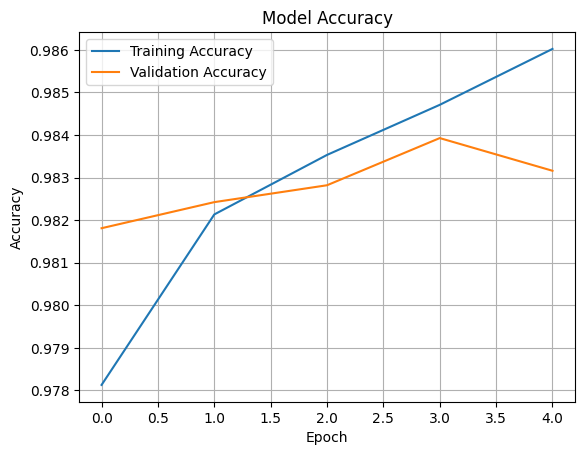

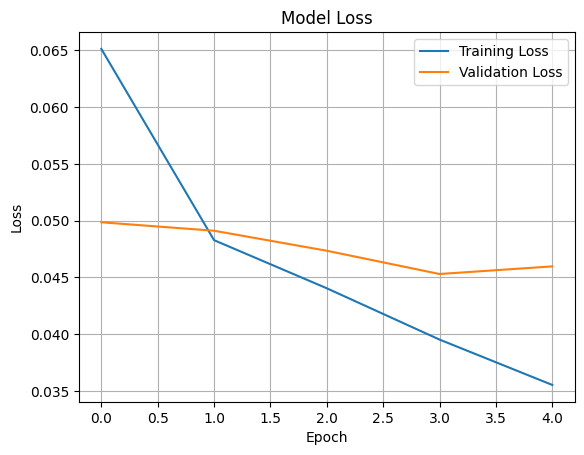

In [26]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


<Figure size 800x500 with 0 Axes>

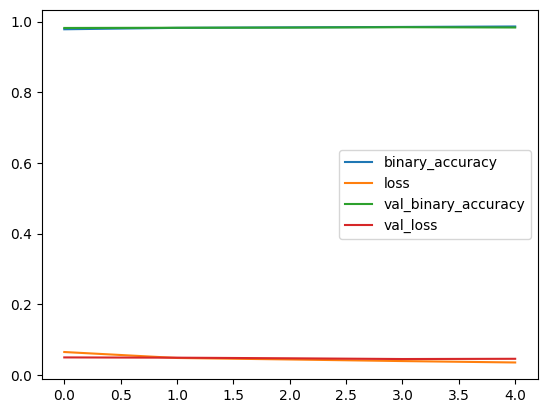

In [27]:
from matplotlib import pyplot as plt
plt.figure(figsize = (8, 5))
pd.DataFrame(history.history).plot()
plt.show()

# **4. Make Predictions**

In [28]:
input_text = vectorizer('I hate you and I am going to hurt you')

In [33]:
input_text = tf.convert_to_tensor(["I hate you and I am going to hurt you"])

In [36]:
vectorized_input = vectorizer(input_text)

In [37]:
res = model.predict(vectorized_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


In [38]:
(res > 0.5).astype(int)

array([[1, 0, 0, 0, 0, 0]])

In [39]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [40]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [41]:
res.shape

(1, 6)

# **5. Evaluate Model**

In [42]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [43]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [44]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 

In [45]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8311591744422913, Recall:0.6499562859535217, Accuracy:0.46840521693229675


# **6. Test and Gradio**

In [46]:
!pip install gradio jinja2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 112.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.2 MB/s eta 0:00:00


In [59]:
import tensorflow as tf
import gradio as gr

In [60]:
model.save("toxicity.keras")

In [61]:
model = tf.keras.models.load_model('toxicity.keras')

In [62]:
input_str = vectorizer('hey i freaken hate you!')

In [63]:
res = model.predict(np.expand_dims(input_str,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


In [64]:
res

array([[0.8983464 , 0.01689055, 0.21782307, 0.02739089, 0.50937366,
        0.07511551]], dtype=float32)

In [65]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)

    return text

In [70]:
import gradio as gr

interface = gr.Interface(
    fn=score_comment,
    inputs=gr.Textbox(lines=2, placeholder="Enter a comment to score"),
    outputs=gr.Text()
)

interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6c2cae68d1439e4e9a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
